<a href="https://colab.research.google.com/github/pankaj90382/TSAI/blob/master/S5/EVA4_Session_5_Approach2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU()) 
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU())
        self.convblock3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU())
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU())
        self.convblock6 = nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU())
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU())
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=7)) # output_size = 1
        self.convblock9 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        #self.conv6 = nn.Conv2d(32, 32, 3)
        #self.conv7 = nn.Conv2d(32, 10, 3)

    def forward(self, x):
        x = self.convblock1(x) #input - 28; Output - 28; RF - 3; output channels - 8
        x = self.convblock2(x) #input - 28; Output - 28; RF - 5; output channels - 16
        x = self.convblock3(x) #input - 28; Output - 28; RF - 5; output channels - 8
        x = self.pool1(x) #input - 28; Output - 14; RF - 6; output channels - 8
        x = self.convblock4(x)#input - 14; Output - 14; RF - 10; output channels - 16
        x = self.convblock5(x)#input - 14; Output - 14; RF - 14; output channels - 32
        x = self.convblock6(x)#input - 14; Output - 14; RF - 14; output channels - 8
        x = self.pool1(x) #input - 14; Output - 7; RF - 16; output channels - 8
        x = self.convblock7(x) #input - 7; Output - 7; RF - 24; output channels - 16
        x = self.convblock8(x)  #input - 7; Output - 7; RF - 32; output channels - 16
        x = self.gap(x)        
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           1,152
              ReLU-4           [-1, 16, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             128
         MaxPool2d-6            [-1, 8, 14, 14]               0
            Conv2d-7           [-1, 16, 14, 14]           1,152
              ReLU-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 32, 14, 14]           4,608
             ReLU-10           [-1, 32, 14, 14]               0
           Conv2d-11            [-1, 8, 14, 14]             256
        MaxPool2d-12              [-1, 8, 7, 7]               0
           Conv2d-13             [-1, 16, 7, 7]           1,152
             ReLU-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)
        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
        
        # Predict
        y_pred = model(data)
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=2.302605152130127 batch_id=468 Accuracy=9.86: 100%|██████████| 469/469 [00:11<00:00, 42.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 958/10000 (9.58%)

EPOCH: 1


loss=2.302534341812134 batch_id=468 Accuracy=9.86: 100%|██████████| 469/469 [00:10<00:00, 42.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 958/10000 (9.58%)

EPOCH: 2


loss=2.3025290966033936 batch_id=468 Accuracy=9.86: 100%|██████████| 469/469 [00:10<00:00, 44.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 958/10000 (9.58%)

EPOCH: 3


loss=2.302647829055786 batch_id=468 Accuracy=10.27: 100%|██████████| 469/469 [00:10<00:00, 45.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3025, Accuracy: 1146/10000 (11.46%)

EPOCH: 4


loss=2.302314043045044 batch_id=468 Accuracy=12.45: 100%|██████████| 469/469 [00:10<00:00, 44.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3025, Accuracy: 1011/10000 (10.11%)

EPOCH: 5


loss=2.3021819591522217 batch_id=468 Accuracy=9.92: 100%|██████████| 469/469 [00:10<00:00, 44.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3023, Accuracy: 980/10000 (9.80%)

EPOCH: 6


loss=2.303258180618286 batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:10<00:00, 43.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2948, Accuracy: 980/10000 (9.80%)

EPOCH: 7


loss=2.3035056591033936 batch_id=468 Accuracy=11.54: 100%|██████████| 469/469 [00:10<00:00, 44.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3024, Accuracy: 998/10000 (9.98%)

EPOCH: 8


loss=2.294227361679077 batch_id=468 Accuracy=10.46: 100%|██████████| 469/469 [00:10<00:00, 44.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2957, Accuracy: 1135/10000 (11.35%)

EPOCH: 9


loss=1.794682502746582 batch_id=468 Accuracy=14.47: 100%|██████████| 469/469 [00:11<00:00, 45.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8928, Accuracy: 2448/10000 (24.48%)

EPOCH: 10


loss=0.42256617546081543 batch_id=468 Accuracy=66.11: 100%|██████████| 469/469 [00:10<00:00, 44.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4339, Accuracy: 8635/10000 (86.35%)

EPOCH: 11


loss=0.27877572178840637 batch_id=468 Accuracy=89.71: 100%|██████████| 469/469 [00:10<00:00, 44.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2168, Accuracy: 9317/10000 (93.17%)

EPOCH: 12


loss=0.17462174594402313 batch_id=468 Accuracy=93.70: 100%|██████████| 469/469 [00:10<00:00, 46.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1762, Accuracy: 9461/10000 (94.61%)

EPOCH: 13


loss=0.31662389636039734 batch_id=468 Accuracy=94.98: 100%|██████████| 469/469 [00:10<00:00, 45.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1541, Accuracy: 9516/10000 (95.16%)

EPOCH: 14


loss=0.07139317691326141 batch_id=468 Accuracy=95.99: 100%|██████████| 469/469 [00:10<00:00, 44.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1000, Accuracy: 9687/10000 (96.87%)

EPOCH: 15


loss=0.14581532776355743 batch_id=468 Accuracy=96.66: 100%|██████████| 469/469 [00:10<00:00, 45.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1005, Accuracy: 9694/10000 (96.94%)

EPOCH: 16


loss=0.06317783147096634 batch_id=468 Accuracy=97.15: 100%|██████████| 469/469 [00:10<00:00, 44.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1096, Accuracy: 9639/10000 (96.39%)

EPOCH: 17


loss=0.02150527574121952 batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:09<00:00, 47.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0734, Accuracy: 9767/10000 (97.67%)

EPOCH: 18


loss=0.057488858699798584 batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:10<00:00, 46.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0832, Accuracy: 9750/10000 (97.50%)

EPOCH: 19


loss=0.0512491911649704 batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:10<00:00, 45.46it/s]



Test set: Average loss: 0.0677, Accuracy: 9789/10000 (97.89%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

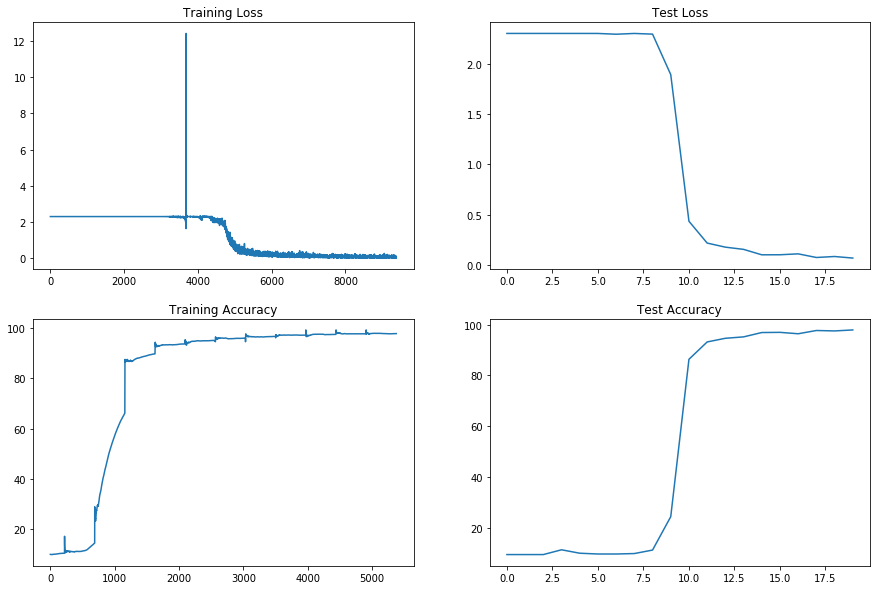

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Approach 2 - 

Problem - Improve the Initial training phase of model by using only Batch Normalization. It will increase the parameters in my model up to >11k. 

Used parameters -11,192<br>
Human's based performance -99.7<br>
Maximum Train Accuracy Achieved -99.72<br>
Maximum Test Accuracy Achieved - 99.14<br>
Maximum - Epoch -20<br>

Observations - Wow, by introducing only batch normalization, my model's initial phase accuracy jump to 87% (in first epoch. However in previous approach it is 9.5%). By lookin at the log's. reach to conclusion my model is overfitting. The difference between my training accuracy and test accuracy is very high. By looking at logs the Learning rate may be big, need to reduce after epoch, the training accuracy decreases and then increases.
